In [5]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

In [219]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
#         legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [7]:
function routine_plot(state::Vector{Float64}, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = cylinder_state_to_lagrange(state, config)
    Z = X .+ im*Y'
    ψ = imag.(LowRankVortex.F(Z, source))
    
    plt = plot(collect(X), collect(Y), ψ', ratio = 1.0, colorbar = false, 
                      xlim = (X[1], X[end]), 
                      ylim = (Y[1], Y[end]); levels = 10)
    
        
    θc = range(0,2π,length=201)
    zc = exp.(im*θc[1:end-1])
    plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
    
    if withvortices == true
        plot!(plt, source, markersize = 4, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

routine_plot(blobs, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true) = 
routine_plot(cylinder_lagrange_to_state(blobs, config), config, X, Y; withvortices=withvortices)


routine_plot (generic function with 2 methods)

### Configuration setup

In [103]:
# grid for evaluation
xgrid = range(-4,4,length=201)
ygrid = copy(xgrid)
zgrid = xgrid .+ im*ygrid';

# sensors on the unit circle
θsensors = range(0,2π,length=31)[1:end-1]
sensors = exp.(im*θsensors)

t0 = 0.0
tf = 2.0
tspan = (t0, tf)

# create configuration file
config_data = let Nv = 8, U = complex(0.0), 
             ss = sensors, Δt = 5e-3, δ = 1e-3,
             ϵX = 1e-3, ϵΓ = 1e-3,
             β = 1.0,
             ϵY = 1e-3
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Ny = length(config_data.ss)
Nx = 3*config_data.Nv

24

### Generate the truth used in the twin experiment

In [135]:
σθ = 0.05*(2*π/(config_data.Nv))
θv = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)

r0 = 2.5
σr = 0.05*r0
rv = r0 .+ σr*randn(config_data.Nv)

Γ0 = 10.0
σΓ = 0.05*Γ0
zv = rv .* exp.(im*θv)
Γv = Γ0 .+ σΓ*randn(config_data.Nv)

blobs = Vortex.Blob.(zv, Γv,config_data.δ*ones(config_data.Nv))

data = generate_data_cylinder_twin_experiment(deepcopy(blobs), t0, tf, config_data,
       "/media/mat/HDD/LowRankVortex.jl/localization/")

tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/localization/data_cylinder_twin_experiment.jld", 
                      "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  1.955, 1.96, 1.965, 1.97, 1.975, 1.98, 1.985, 1.99, 1.995, 2.0], 0.005, [2.675968759666415, 0.11227447874469879, 9.622674127045562, 1.6846334900467563, 1.6223203132299855, 10.275113564992317, -0.008033844837482361, 2.616124970175922, 9.752232396247267, -2.060231241724534  …  9.536252653960291, -1.7030569371240898, -1.6022223290450421, 10.017092123372507, 0.03307609347909396, -2.5351627633447875, 9.318112396102533, 1.77426453522717, -2.039019781138546, 9.378816939103448], [2.6749433304403047 2.6753864034870776 … -0.3354642466741963 -0.3488239420988891; 0.11084160687371157 0.12482782553593336 … 3.060114061480856 3.058566308743873; … ; -2.0394789939989866 -2.0303782258036214 … 1.493853302537101 1.4980753509434994; 9.378428887494627 9.37846081716719 … 9.396737662116903 9.398344668113593], [-10.002636486486704 -10.000149624173616 … -10.238208402694955 -10.23138449344135; -10.197692130328575 -10.194401067334736

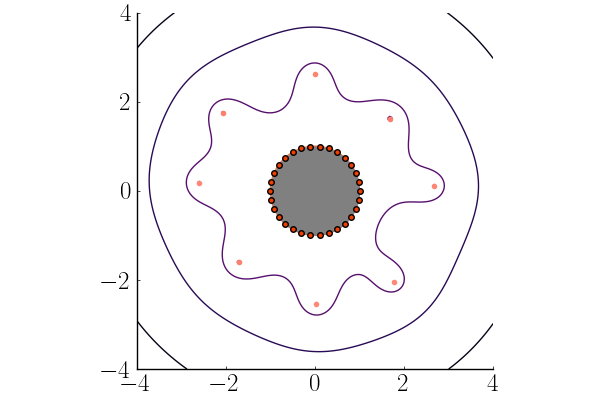

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [220]:
routine_plot(blobs, config_data, xgrid, ygrid)

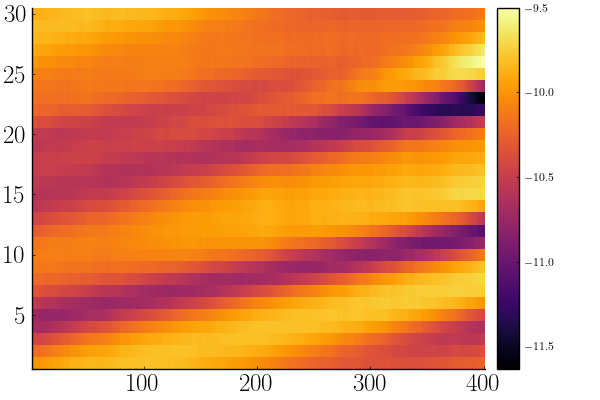

In [221]:
heatmap(data.yt)

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


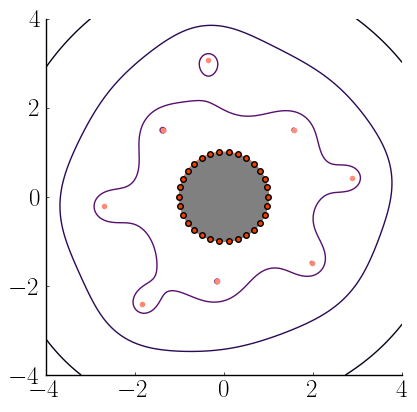

Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
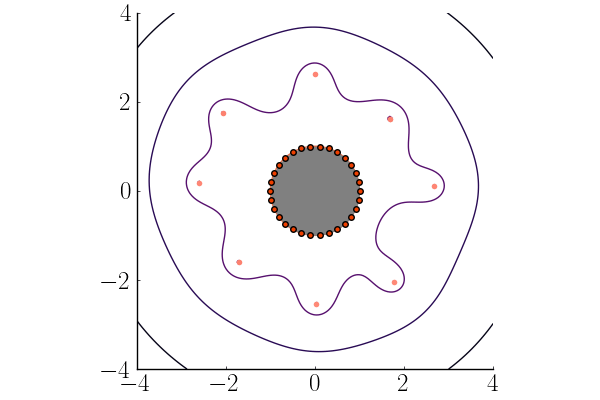

In [222]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid)
    next!(prog)
end

### Setup of the ensemble filter

In [223]:
config = deepcopy(config_data)

VortexConfig(8, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9781476007338057 + 0.20791169081775931im, 0.9135454576426009 + 0.40673664307580015im, 0.8090169943749475 + 0.5877852522924731im, 0.6691306063588582 + 0.7431448254773941im, 0.5000000000000001 + 0.8660254037844386im, 0.30901699437494745 + 0.9510565162951535im, 0.10452846326765368 + 0.9945218953682733im, -0.10452846326765333 + 0.9945218953682734im, -0.30901699437494734 + 0.9510565162951536im  …  -0.5000000000000004 - 0.8660254037844385im, -0.30901699437494756 - 0.9510565162951535im, -0.10452846326765423 - 0.9945218953682733im, 0.10452846326765299 - 0.9945218953682734im, 0.30901699437494723 - 0.9510565162951536im, 0.49999999999999933 - 0.866025403784439im, 0.6691306063588578 - 0.7431448254773946im, 0.8090169943749473 - 0.5877852522924734im, 0.9135454576426005 - 0.40673664307580093im, 0.9781476007338056 - 0.20791169081775987im], 0.005, 0.001, 0.001, 0.001, 1.0, 0.001)

In [224]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

senkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = false)
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = false)

LREnKF  with filtered = false


In [241]:
# Generate the initial condition

Ne = 100

X0 = zeros(Ny+Nx, Ne)


for i=1:Ne
    θi = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)
    ri = r0 .+ σr*randn(config_data.Nv)
    zi = ri .* exp.(im*θi)
    Γi = Γ0 .+ σΓ*randn(config_data.Nv)
    
    bi = Vortex.Blob.(zi,Γi,config_data.δ*ones(config_data.Nv))
    X0[Ny+1:Ny+Nx,i] = cylinder_lagrange_to_state(bi, config_data)
end

X = deepcopy(X0);

In [242]:
timeidx = 101:401

101:401

In [243]:
@time Xf, Xa = senkf_cylinder_vortexassim(senkf, deepcopy(X0), tspan, config, data)

rmse_enkf = mean((norm.(eachcol(mean_hist(Xa)-data.xt)))[timeidx])/sqrt(size(data.x0,1))

 27.800390 seconds (11.57 M allocations: 2.686 GiB, 3.94% gc time)


0.2365712533689751

In [244]:
function circleshape(x0, y0, R)
    θ = LinRange(0, 2*π, 501)
    x0 .+ R*cos.(θ), y0 .+ R*sin.(θ)
end

circleshape (generic function with 1 method)

In [245]:
Lxy = 1.0
Lyy = 0.5

0.5

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


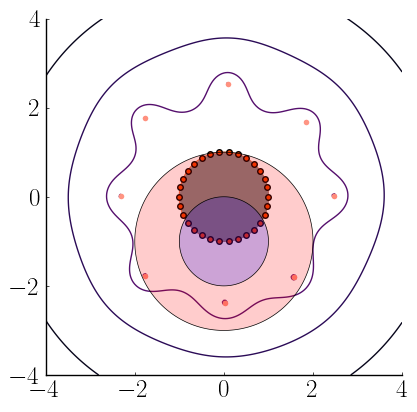

In [246]:
routine_plot(X[Ny+1:Ny+Nx,1], config_data, xgrid, ygrid)
plot!(circleshape(0, -1, 2*Lxy), seriestype = [:shape], lw = 0.5, 
                           c= :red, ratio = 1, legend = false, fillalpha = 0.2, aspect_ratio = 1)
plot!(circleshape(0, -1, 2*Lyy), seriestype = [:shape], lw = 0.5, 
                           c= :blue, ratio = 1, legend = false, fillalpha = 0.2, aspect_ratio = 1)

savefig("setup.png")

In [247]:
@time Xflocalized, Xalocalized = localized_senkf_cylinder_vortexassim(senkf, 
                                                                Lxy, Lyy, deepcopy(X0), tspan, config, data)

rmse_localized_enkf = mean(norm.(eachcol(mean_hist(Xalocalized)-data.xt))[timeidx]/sqrt(size(data.x0,1)))

 18.749672 seconds (11.68 M allocations: 2.787 GiB, 2.28% gc time)


0.19968265208738112

In [248]:
@time Xflowrank, Xalowrank, rxhist, ryhist = adaptive_lowrankenkf_cylinder_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data;  
                                                             isadaptive = true,
                                                             ratio = 0.99)

rmse_lowrank = mean(norm.(eachcol(mean_hist(Xalowrank)-data.xt))[timeidx]/sqrt(size(data.x0,1)))

119.988136 seconds (15.81 M allocations: 6.149 GiB, 0.34% gc time)


0.2863528054845619

In [198]:
h(x,t) = measure_state_cylinder(x, t, config)

h (generic function with 1 method)

In [231]:
Xmeas = zero(X0)
Xmeas[Ny+1:Ny+Nx,:] .= Xflowrank[101]
for i=1:Ne
    observe(h, Xmeas, 0.0, Ny, Nx)
end

Emeas = senkf.ϵy.σ*randn(Ny, Ne) .+ senkf.ϵy.m

30×50 Matrix{Float64}:
 -0.00104648    0.000559335  -0.00123277   …  -0.000547478   0.000473466
 -0.000350246   0.00105513    6.32439e-5      -0.000415945  -0.00226017
 -0.00139481    0.00125408   -0.000455669      0.00151185    0.000473617
 -0.000237604  -0.000699374   0.00125378       0.000222574   0.00128631
 -0.000539878   0.000664636   0.00137624      -0.000834721  -0.00185474
 -4.15885e-5   -0.000978869   0.00046282   …   0.000732558  -0.00121848
  0.000655597  -0.00030194   -0.000846491      0.000234421   0.0013584
 -0.000276413  -0.000112538   0.000380377     -0.00107047    0.00145402
 -0.00184834   -0.000126252   0.000392043      0.000605603  -0.000786701
  0.000247419  -0.0011158    -0.00263207       0.000998653  -0.000461193
 -2.35681e-5    1.5123e-6     0.00116182   …   0.00128936   -0.00104376
  0.000933015   0.000230306  -0.000288491      0.00112194   -0.00143375
 -0.00223402    0.00012651   -0.000790951     -0.000139731   0.000344342
  ⋮                                  

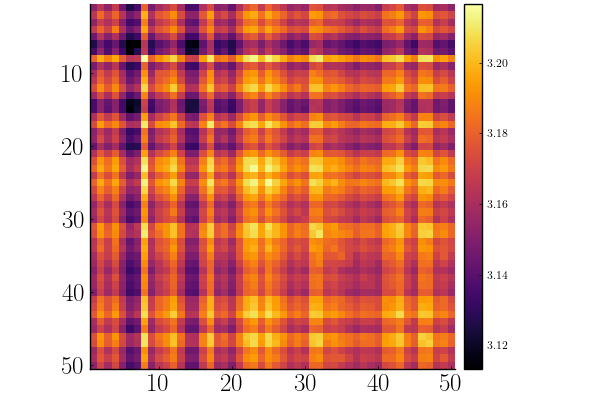

In [232]:
heatmap(log.(abs.(cov(Xmeas[Ny+1:Ny+Nx,:])')), yflip = true, ratio = 1.0, xlims = (-Inf, Inf))

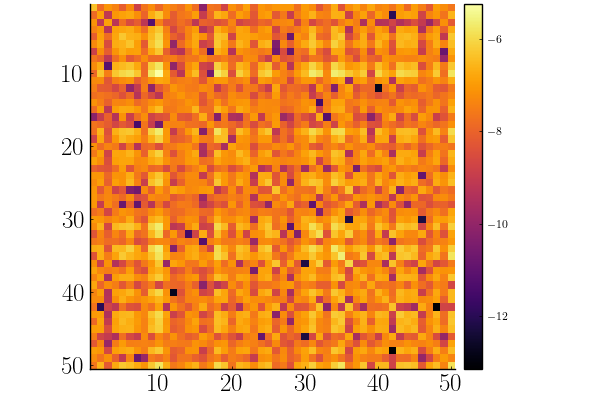

In [233]:
heatmap(log.(abs.(cov(Xmeas[1:Ny,:])' + cov(Emeas)')), yflip = true, ratio = 1.0, xlims = (-Inf, Inf))

In [234]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)

Jac = zeros(Ny, Nx)

Xjac = Xflocalized[201]

Dx = Diagonal(std(Xjac; dims = 2)[:,1])
Dϵ = config.ϵY*I

@inbounds for j=1:Ne
    cylinder_analytical_jacobian_pressure!(Jac, config.ss, cylinder_state_to_lagrange(Xjac[:,j], config))

    Cx .+= 1/(Ne-1)*(inv(Dϵ)*Jac*Dx)'*(inv(Dϵ)*Jac*Dx)
    Cy .+= 1/(Ne-1)*(inv(Dϵ)*Jac*Dx)*(inv(Dϵ)*Jac*Dx)'
end

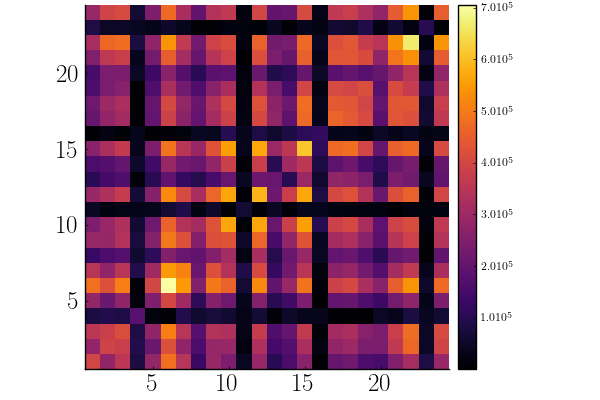

In [235]:
heatmap(abs.(Cx), ratio = 1.0, xlims = (-Inf, Inf))

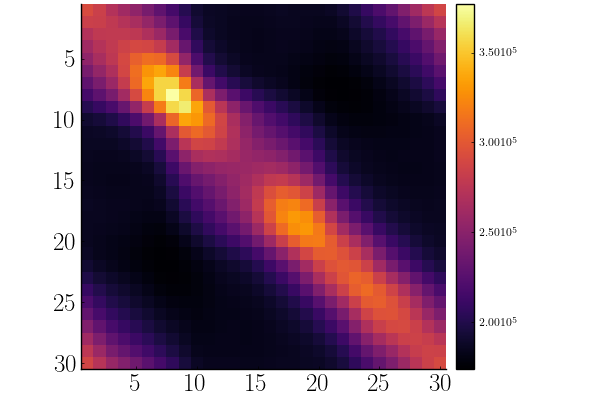

In [236]:
heatmap(abs.(Cy)', yflip = true, ratio = 1.0, xlims = (-Inf, Inf))

In [237]:
Vx, Λx, _ = svd(Symmetric(Cx));

In [238]:
Uy, Λy, _ = svd(Symmetric(Cy));

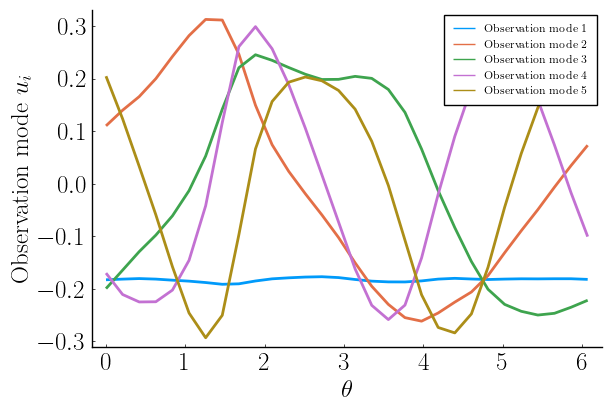

In [240]:
plt = plot(xlabel = L"\theta", ylabel = "Observation mode "*L"u_i")

for i=1:5
    plot!(plt, θsensors, Uy[:,i], linewidth = 2, label = "Observation mode "*latexstring(i))
end
#scatter!(plt, θsensors, zero(θsensors), markersize = 5)

plt

savefig("observation_modes.png")

In [191]:
function energy_ratio(Σ)
    Λ = svd(Symmetric(Σ)).S
    return cumsum(Λ)./sum(Λ)
end

energy_ratio (generic function with 1 method)

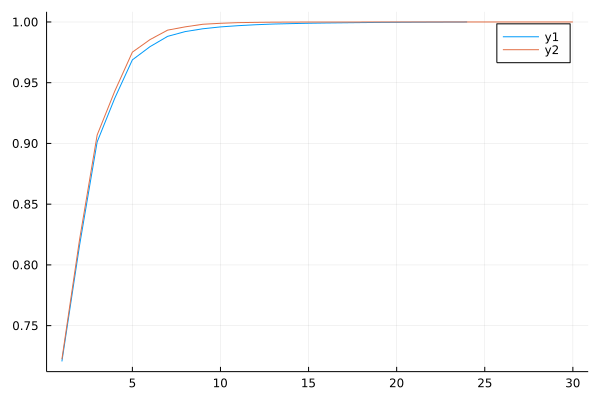

In [192]:
plot(energy_ratio(Cx))
plot!(energy_ratio(Cy))

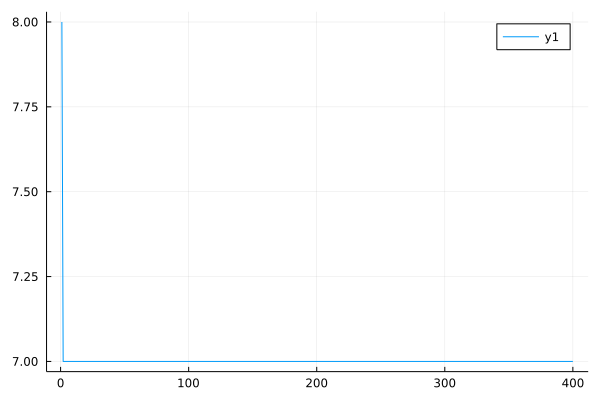

In [165]:
plot(ryhist)

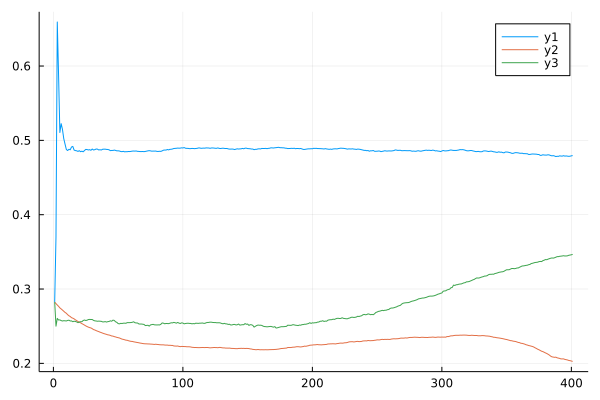

In [166]:
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)))
plot!(norm.(eachcol(mean_hist(Xalocalized)-data.xt))/sqrt(size(data.x0,1)))
plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)))


In [27]:
plt = plot(legend = false)
for i=1:Ne
    plot!(plt, h(Xa[2][:,i],0.0))
end
plt

plot!(plt, data.yt[:,2], linewidth = 10)
plt

LoadError: UndefVarError: h not defined

In [28]:
norm(mean(X0[Ny+1:Ny+Nx,:]; dims = 2)[:,1]-data.xt[:,1])

0.0

In [29]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = plot(legend = false, ylim = (-8.20, -7.8))
    for i=1:Ne
        plot!(plt, h(Xa[nsnap][:,i],0.0))
    end
    plot!(plt, data.yt[:,nsnap], linewidth = 3, color = colorant"firebrick3")
    next!(prog)
end

LoadError: UndefVarError: h not defined

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
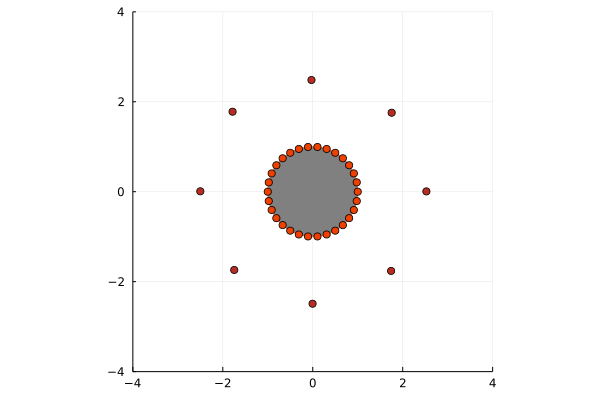

In [139]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config_data, xgrid, ygrid)
    next!(prog)
end

In [140]:
J = zeros(length(config_data.ss), Nx)

@time for i=1:config_data.Nv
    dpdzi = dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xflowrank[end][:,1], config_data); ϵ = config_data.δ)
    J[:,3*i-2] .= 2*real(dpdzi)  
    J[:,3*i-1] .= -2*imag(dpdzi)
    
    dpdΓi = dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xflowrank[1][:,1], config_data); ϵ = config_data.δ)
    J[:,3*i] .= dpdΓi
end

  0.045794 seconds (16.92 k allocations: 860.073 KiB, 99.21% compilation time)


In [205]:
Jbis = cylinder_analytical_jacobian_pressure(config_data.ss, 
       cylinder_state_to_lagrange(Xf[1][:,1], config_data))

30×42 Matrix{Float64}:
 2.63239  -0.203418   -0.748116  1.30259   …  2.74917  -2.03152   -0.636863
 2.51437  -0.93303    -0.728436  1.75585      2.38555  -1.90237   -0.58315
 2.2724   -1.3188     -0.682057  2.36047      2.10196  -1.66732   -0.530285
 2.02668  -1.3438     -0.6238    2.85574      1.89634  -1.42581   -0.484568
 1.82578  -1.17038    -0.56642   3.02682      1.74884  -1.21994   -0.447328
 1.67063  -0.94353    -0.51668   2.90342   …  1.64106  -1.0583    -0.417851
 1.55141  -0.733888   -0.476327  2.63591      1.56039  -0.935917  -0.394825
 1.45888  -0.562447   -0.444571  2.34195      1.49849  -0.844381  -0.376894
 1.38642  -0.429757   -0.419988  2.0784       1.44961  -0.776459  -0.362941
 1.33081  -0.329789   -0.401397  1.86367      1.41062  -0.727209  -0.352296
 1.29057  -0.254124   -0.387833  1.69637   …  1.38079  -0.692678  -0.344614
 1.26357  -0.194063   -0.37828   1.56616      1.36025  -0.668603  -0.339583
 1.24627  -0.143328   -0.371693  1.46212      1.34828  -0.650929  

In [206]:
U, Λ, V = svd(J);

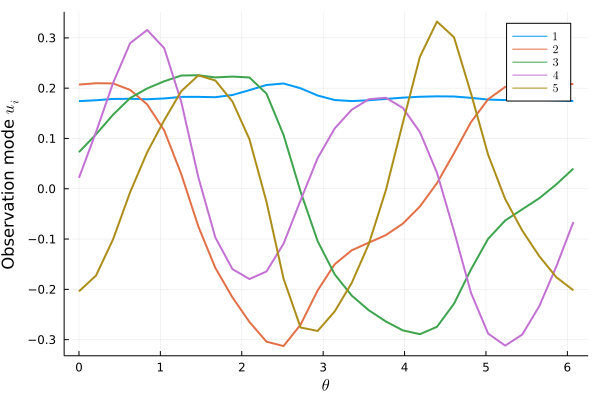

In [207]:
plt = plot(xlabel = L"\theta", ylabel = "Observation mode "*L"u_i")

for i=1:5
    plot!(plt, θsensors, U[:,i], linewidth = 2, label = latexstring(i))
end
#scatter!(plt, θsensors, zero(θsensors), markersize = 5)

plt

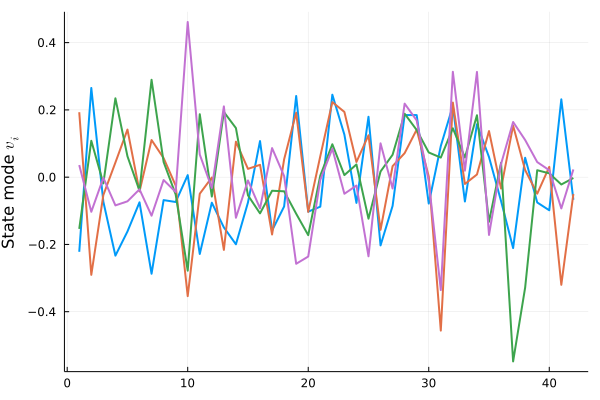

In [208]:
plt = plot(ylabel = "State mode "*L"v_i", legend = false)

for i=1:4
    plot!(plt, V[:,i], linewidth = 2)
end
plt

In [209]:
Cy = J*J'
Λy = sqrt.(svd(Cy).S)
cumsum((Λy.^2)./sum(Λy.^2))

30-element Vector{Float64}:
 0.7500619217395121
 0.8440358720801033
 0.9136489321148873
 0.9513574896328686
 0.974670145163168
 0.9856317001190096
 0.9938364349189636
 0.996399602297371
 0.9984579248035105
 0.9991624823940324
 0.9996652126933029
 0.9998213575199153
 0.9999351074766273
 ⋮
 0.9999996439055443
 0.9999998435596484
 0.9999999650658378
 0.9999999808527931
 0.9999999944255549
 0.9999999983392054
 0.999999999380104
 0.9999999997489478
 0.9999999999382054
 0.999999999970367
 0.9999999999959288
 1.0000000000000002

In [210]:
Cx = J'*J
Λx = sqrt.(svd(Cx).S)
cumsum((Λx.^2)./sum(Λx.^2))

42-element Vector{Float64}:
 0.7500619217395105
 0.8440358720801014
 0.9136489321148853
 0.9513574896328667
 0.9746701451631661
 0.9856317001190077
 0.9938364349189617
 0.9963996022973691
 0.9984579248035086
 0.9991624823940304
 0.999665212693301
 0.9998213575199133
 0.9999351074766253
 ⋮
 0.9999999999999987
 0.9999999999999988
 0.9999999999999989
 0.9999999999999989
 0.999999999999999
 0.9999999999999991
 0.9999999999999991
 0.9999999999999992
 0.9999999999999993
 0.9999999999999994
 0.9999999999999996
 0.9999999999999996

In [211]:
(cumsum(Λ.^2)./sum(Λ.^2))

30-element Vector{Float64}:
 0.7500619217395119
 0.844035872080103
 0.9136489321148871
 0.9513574896328684
 0.9746701451631679
 0.9856317001190096
 0.9938364349189636
 0.996399602297371
 0.9984579248035104
 0.9991624823940323
 0.9996652126933028
 0.9998213575199152
 0.9999351074766272
 ⋮
 0.9999996439055443
 0.9999998435596482
 0.9999999650658378
 0.9999999808527931
 0.9999999944255548
 0.9999999983392053
 0.999999999380104
 0.9999999997489478
 0.9999999999382054
 0.9999999999703669
 0.9999999999959287
 1.0000000000000002

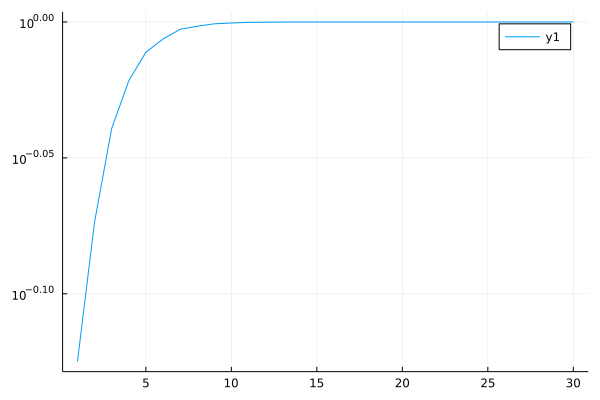

In [212]:
plot(cumsum(Λy.^2)./sum(Λy.^2), yscale = :log10)

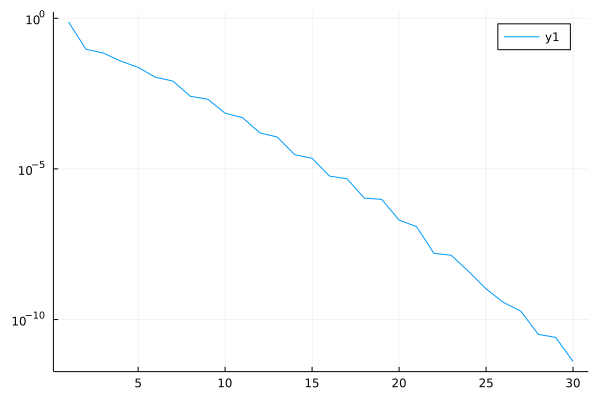

In [213]:
plot((Λ.^2)./sum(Λ.^2), yscale = :log10)

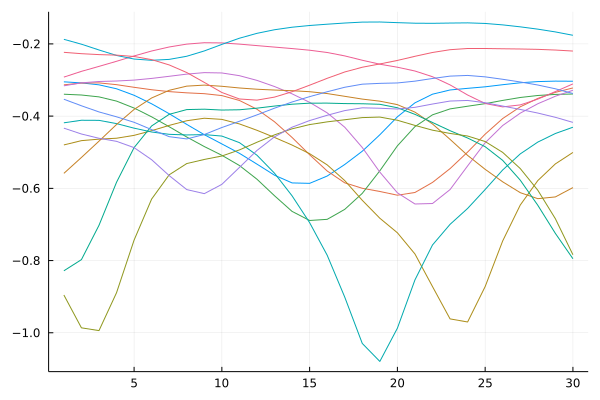

In [214]:
plt = plot(legend = false)

for i=1:config_data.Nv
    #plot!(plt, real(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    #plot!(plt, imag(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    plot!(plt, dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))
end
plt

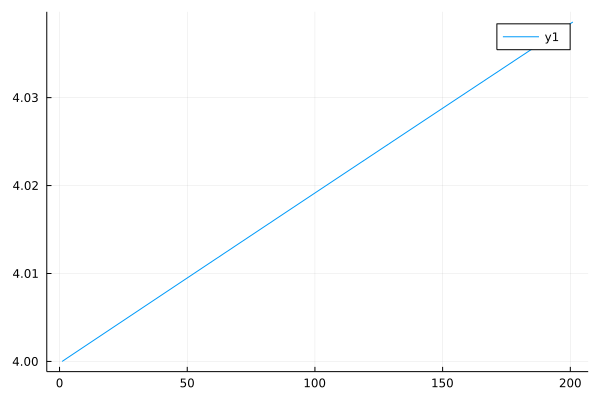

In [23]:
plot(map(xi -> xi[1]^2 + xi[2]^2, Xf))

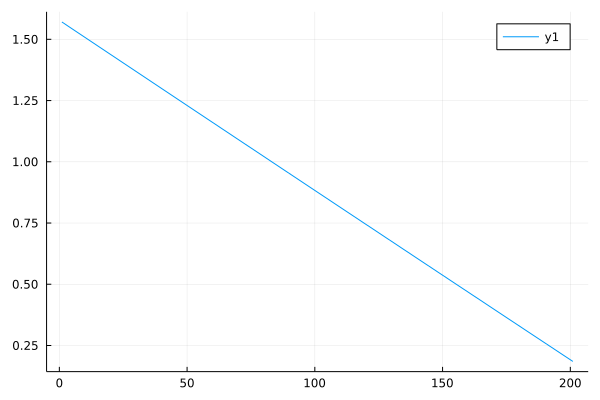

In [24]:
plot(map(xi -> atan(xi[1], xi[2]), Xf))

In [25]:
-ΓJ/(4*π^2*(abs2(zJ)*(abs2(zJ)-1)))

-0.626347670570229

In [26]:
10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.5524030608054593 + 1.4966356498690878im, 1.777087057229044, 1.0e-7)
 Vortex.Blob(0.30297956811366955 - 1.5310233453394266im, 2.9950386389152985, 1.0e-7)
 Vortex.Blob(1.9533834668703678 + 1.5266552994597413im, 1.2339447083625958, 1.0e-7)
 Vortex.Blob(-1.0513133042403213 - 1.8227794557170132im, 1.6223707566499805, 1.0e-7)
 Vortex.Blob(-1.0836095985941654 + 0.7843079480127662im, 1.2450142628958365, 1.0e-7)
 Vortex.Blob(1.3467972420595151 + 0.7119955880276292im, 2.3945872015751033, 1.0e-7)
 Vortex.Blob(-1.543405087720262 - 0.948819867733115im, 2.391208846205823, 1.0e-7)
 Vortex.Blob(1.7504807284205954 - 1.4213977275321987im, 1.3496791100069796, 1.0e-7)
 Vortex.Blob(-1.2616569955408155 + 0.3668878315302502im, 1.7170363502434927, 1.0e-7)
 Vortex.Blob(0.9089535560506601 - 1.9950164010242206im, 1.6791417364879595, 1.0e-7)

LoadError: syntax: extra token "Vector" after end of expression